# Aurora inference & fine-tuning in Azure ML

This notebook explains the workflow and submits an Azure Machine Learning (AML) job that runs **Microsoft Aurora** on a GPU cluster.

## Files used in this workshop

We use the following components:

1. `notebooks/0_aurora_workshop.ipynb` *(this notebook)* – explains the workflow and submits jobs to AML:
   - <mark>Run this notebook with a CPU Compute Instance using the "Python 3.10 - SDK v2" kernel</mark>
2. `setup/components/inference` - contains Aurora inference logic:
   - `main.py`: a script with a CLI interface for running a simple inference loop.
   - `component.py`: AML component definition.
3. `setup/components/training` - contains Aurora fine-tuning logic:
   - `main.py`: a script with a CLI interface for running a simple fine-tuning loop.
   - `component.py`: AML component definition.
4. `setup/components/common/utils.py` - contains Aurora helper logic, including:
   - Loading model checkpoints in train or eval mode.
   - Loading data on disk into `aurora.Batch` objects for inference and fine-tuning.
   - Converting `aurora.Batch` objects into `xarray.Dataset` objects for analysis and writing of data.

**NOTE**: inference and fine-tuning scripts in `setup/components/*/main.py` will work in local and remote environments provided the hardware and dependencies required to run Aurora are present in each. AML component definitions in `setup/components/*/components.py` serve only to deploy and make these scripts executable in AML.

In [ ]:
import sys
from datetime import UTC, datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from azure.ai.ml import Input, Output, PyTorchDistribution
from azure.ai.ml.entities import Command, CommandComponent, CommandJobLimits
from azure.ai.ml.exceptions import JobException, MlException

sys.path.insert(0, str(Path.cwd().parent.resolve()))
from setup.common.utils import create_mlclient, get_latest_asset

In [2]:
PARTICIPANT_ID = input("Enter a participant ID e.g. saadatali").strip()
print(f"Hello, {PARTICIPANT_ID}!")

Hello, duncanmartyn!


Create an `azure.ai.ml.MLClient` object to interact with the workspace and, with this, retrieve the compute cluster, model, and data required to run jobs.

**NOTE**: the `local` parameter expects a boolean argument that decides what environment variables to look for when configuring the `MLClient` object. `True` will look for environment variables set in a local `.env` file in the project root, `False` will look for environment variables automatically set in Azure Machine Learning Compute Instances. See `setup/common/utils.py` for more.

In [ ]:
ml_client = create_mlclient(local=True)
print(
    f"Connected to workspace: sub={ml_client.subscription_id}, "
    f"rg={ml_client.resource_group_name}, workspace={ml_client.workspace_name}",
)

# get the name of the first AML compute cluster (type="amlcompute") in the workspace
CLUSTER_NAME = next(iter(ml_client.compute.list(compute_type="amlcompute"))).name

# get the latest pre-trained Aurora 0.25 model registered in the workspace
model = get_latest_asset(ml_client.models, name="aurora-0p25-pretrained")
MODEL_NAME = f"azureml:{model.name}:{model.version}"

# get the latest ERA5 subset data asset registered in the workspace
data = get_latest_asset(ml_client.data, name="workshop-test-asset")
DATA_NAME = f"azureml:{data.name}:{data.version}"

print(f"Using assets: cluster={CLUSTER_NAME}, model={MODEL_NAME}, data={DATA_NAME}")

Overriding of current TracerProvider is not allowed


Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


Connected to workspace: sub=62118f5c-be37-400f-9f20-a8b77a2a7877, rg=data-science-team-rg, workspace=data-science-team-workspace
Using assets: cluster=test-cluster, model=azureml:aurora-0p25-pretrained:2, data=azureml:workshop-test-asset:6


## Test data inference job

Here, we'll run a test inference job using generated synthetic test data comprising a low resolution tensor of random float values.

In [ ]:
display_name = f"{PARTICIPANT_ID}-{datetime.now(UTC).strftime('%Y%m%d-%H%M%S')}"
inference_component: CommandComponent = get_latest_asset(
    ml_client.components,
    name="wstest_aurora_inference", # "aurora-inference",
)
test_inference_command = Command(
    component=inference_component,
    display_name=display_name,
    experiment_name="inference-test",
    compute="duncanmartyn-gpu",
    inputs={
        "model": Input(type="custom_model", path=MODEL_NAME, mode="ro_mount"),
        "data": Input(type="uri_folder", path=DATA_NAME, mode="ro_mount"),
        "start_datetime": "2026-01-01T00:00:00",  # initial state timestamp
        "steps": 4,  # number of autoregressive inference steps to perform
        "mode": "test",  # enable test mode to use synthetic data
    },
    outputs={
        "predictions": Output(
            type="uri_file",
            path=f"azureml://datastores/${{{{default_datastore}}}}/paths/aurora-workshop/output/{PARTICIPANT_ID}/{display_name}/predictions.nc",
            mode="rw_mount",
        ),
    },
    limits=CommandJobLimits(timeout=7200),
    distribution=PyTorchDistribution(process_count_per_instance=1),
    environment=inference_component.environment,
)

print("Submitting test inference job:", display_name)
test_inference_job = ml_client.jobs.create_or_update(test_inference_command)

print("Streaming logs:")
ml_client.jobs.stream(test_inference_job.name)

Submitting test inference job: duncanmartyn-20260109-100409


pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFileJobOutput'> and will be ignored


Streaming logs:
RunId: tough_rainbow_mp9b0bkwm8
Web View: https://ml.azure.com/runs/tough_rainbow_mp9b0bkwm8?wsid=/subscriptions/62118f5c-be37-400f-9f20-a8b77a2a7877/resourcegroups/data-science-team-rg/workspaces/data-science-team-workspace

Execution Summary
RunId: tough_rainbow_mp9b0bkwm8
Web View: https://ml.azure.com/runs/tough_rainbow_mp9b0bkwm8?wsid=/subscriptions/62118f5c-be37-400f-9f20-a8b77a2a7877/resourcegroups/data-science-team-rg/workspaces/data-science-team-workspace



## ERA5 inference job

Here, we'll run an inference job using pre-loaded ERA5 data.

In [ ]:
display_name = f"{PARTICIPANT_ID}-{datetime.now(UTC).strftime('%Y%m%d-%H%M%S')}"
era5_inference_command = Command(
    component=inference_component,
    display_name=display_name,
    experiment_name="inference-era5",
    compute="duncanmartyn-gpu",
    inputs={
        "model": Input(type="custom_model", path=MODEL_NAME, mode="ro_mount"),
        "data": Input(type="uri_folder", path=DATA_NAME, mode="ro_mount"),
        # below timestamp and that -6 hours must exist in the data
        "start_datetime": "2025-01-01T12:00:00",
        "steps": 4,
        "mode": "eval",  # enable eval mode to use ERA5
    },
    outputs={
        "predictions": Output(
            type="uri_file",
            path=f"azureml://datastores/${{{{default_datastore}}}}/paths/aurora-workshop/output/{PARTICIPANT_ID}/{display_name}/predictions.nc",
            mode="rw_mount",
        ),
    },
    limits=CommandJobLimits(timeout=7200),
    distribution=PyTorchDistribution(process_count_per_instance=1),
    environment=inference_component.environment,
)

print("Submitting ERA5 inference job:", display_name)
era5_inference_job = ml_client.jobs.create_or_update(era5_inference_command)

print("Streaming logs:")
ml_client.jobs.stream(era5_inference_job.name)
# NOTE; ready to re-run post lunch, comp updated

Submitting ERA5 inference job: duncanmartyn-20260109-140210


pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFileJobOutput'> and will be ignored


Streaming logs:
RunId: busy_tomato_rb1mbby5t1
Web View: https://ml.azure.com/runs/busy_tomato_rb1mbby5t1?wsid=/subscriptions/62118f5c-be37-400f-9f20-a8b77a2a7877/resourcegroups/data-science-team-rg/workspaces/data-science-team-workspace

Execution Summary
RunId: busy_tomato_rb1mbby5t1
Web View: https://ml.azure.com/runs/busy_tomato_rb1mbby5t1?wsid=/subscriptions/62118f5c-be37-400f-9f20-a8b77a2a7877/resourcegroups/data-science-team-rg/workspaces/data-science-team-workspace



## Test data fine-tuning job

In [ ]:
job_name = f"{PARTICIPANT_ID}-{datetime.now(UTC).strftime('%Y%m%d-%H%M%S')}"
train_component: CommandComponent = get_latest_asset(
    ml_client.components,
    name="aurora-training",
)
test_train_command = Command(
    component=train_component,
    display_name=job_name,
    experiment_name="finetuning-test",
    compute="duncanmartyn-gpu",
    inputs={
        "model": Input(type="custom_model", path=MODEL_NAME, mode="ro_mount"),
        "data": Input(type="uri_folder", path=DATA_NAME, mode="ro_mount"),
        "steps": 4,
        "mode": "test",
    },
    outputs={
        "loss": Output(
            type="uri_file",
            path="azureml://datastores/${{default_datastore}}/paths/${{name}}/loss.npy",
            mode="upload",
        ),
        "prediction": Output(
            type="uri_file",
            path="azureml://datastores/${{default_datastore}}/paths/${{name}}/prediction.nc",
            mode="rw_mount",
        ),
    },
    limits=CommandJobLimits(timeout=7200),
    distribution=PyTorchDistribution(process_count_per_instance=1),
    environment=train_component.environment,
)

print("Submitting test fine-tuning job:", test_train_command.display_name)
test_train_job = ml_client.jobs.create_or_update(test_train_command)

print("Streaming logs:")
ml_client.jobs.stream(test_train_job.name)

## ERA5 fine-tuning job

In [ ]:
job_name = f"{PARTICIPANT_ID}-{datetime.now(UTC).strftime('%Y%m%d-%H%M%S')}"
era5_train_command = Command(
    component=train_component,
    display_name=job_name,
    experiment_name="finetuning-era5",
    compute="duncanmartyn-gpu",
    inputs={
        "model": Input(type="custom_model", path=MODEL_NAME, mode="ro_mount"),
        "data": Input(type="uri_folder", path=DATA_NAME, mode="ro_mount"),
        "steps": 4,
        "mode": "eval",
    },
    outputs={
        "loss": Output(
            type="uri_file",
            path="azureml://datastores/${{default_datastore}}/paths/${{name}}/loss.npy",
            mode="upload",
        ),
        "prediction": Output(
            type="uri_file",
            path="azureml://datastores/${{default_datastore}}/paths/${{name}}/prediction.nc",
            mode="rw_mount",
        ),
    },
    limits=CommandJobLimits(timeout=7200),
    distribution=PyTorchDistribution(process_count_per_instance=1),
    environment=train_component.environment,
)

print("Submitting ERA5 fine-tuning job:", era5_train_command.display_name)
era5_train_job = ml_client.jobs.create_or_update(era5_train_command)

print("Streaming logs:")
ml_client.jobs.stream(era5_train_job.name)

## Plotting and evaluating fine-tuning results

Here, we'll visualise the products of inference with the pre-trained and fine-tuned (on ERA5) Aurora side-by-side.

First, download inference and fine-tuning job outputs and artefacts (logs etc.). This requires the jobs to have completed in a successful state. This, and success in downloading the outputs is verified here.

The following new directories and files tagged with * will be created:
```md
aurora-introductory-workshop/
└── notebooks/
    └── *outputs/
        ├── *inference/
        |   ├── *artifacts/: log files for the job, also visible in the job's "Outputs + logs" tab in the Studio UI.
        |   └── *named-outputs/
        |       └── *predictions/
        |           └── *predictions.nc: forecasts generated in inference with the pre-trained model and ERA5 data.
        └── *training
            ├── *artifacts/: log files for the job, also visible in the job's "Outputs + logs" tab in the Studio UI.
            └── *named-outputs/
                ├── *loss/
                |   └── *loss.npy: loss history (loss values at each step) of fine-tuning.
                └── *prediction/
                    └── *prediction.nc: last forecast generated in inference with the fine-tuned model and ERA5 data.
```


In [ ]:
data_dir = Path("outputs")
data_dir.mkdir(exist_ok=True)
inference_out_dir = data_dir / "inference"
inference_out_dir.mkdir(exist_ok=True)
training_out_dir = data_dir / "training"
training_out_dir.mkdir(exist_ok=True)

try:
    print("Downloading inference job outputs for job:", era5_inference_job.display_name)
    ml_client.jobs.download(
        name=era5_inference_job.name,
        download_path=inference_out_dir,
        all=True,
    )
    print("Downloaded inference job outputs to:", inference_out_dir)

    print("Downloading training job outputs for job:", era5_train_job.display_name)
    ml_client.jobs.download(
        name=era5_train_job.name,
        download_path=training_out_dir,
        all=True,
    )
    print("Downloaded fine-tuning outputs to:", training_out_dir)

except (JobException, MlException) as e:
    print("Failed to download job outputs and logs, has the job succeeded?", e)
    raise

Second, load job outputs.

In [ ]:
inference_ds_path = inference_out_dir / "named-outputs/predictions/predictions.nc"
finetune_ds_path = training_out_dir / "named-outputs/prediction/prediction.nc"
loss_arr_path = training_out_dir / "named-outputs/loss/loss.npy"

inference_ds = xr.open_dataset(inference_ds_path)
finetune_ds = xr.open_dataset(finetune_ds_path)
loss_arr = np.load(loss_arr_path)

Finally, plot pre-trained and fine-tuned model inference 2m temperature, and difference


JOB_NAME: aurora-intro-saadat-20251218-154410
PARTICIPANT_ID: saadat
Downloaded outputs under: job_outputs/aurora-intro-saadat-20251218-154410
Base out_dir on disk: job_outputs/aurora-intro-saadat-20251218-154410/named-outputs/out_dir
Expected participant output dir: job_outputs/aurora-intro-saadat-20251218-154410/named-outputs/out_dir/saadat
Files in participant dir:
 - finetune_last_2t.npy
 - finetune_last_prediction.npz
 - finetune_losses.json
 - finetune_losses.npy
 - inference_2t.npy
 - inference_full_prediction.npz
Inference 2t shape: (1, 1, 16, 32)
Finetune 2t shape: (1, 1, 16, 32)


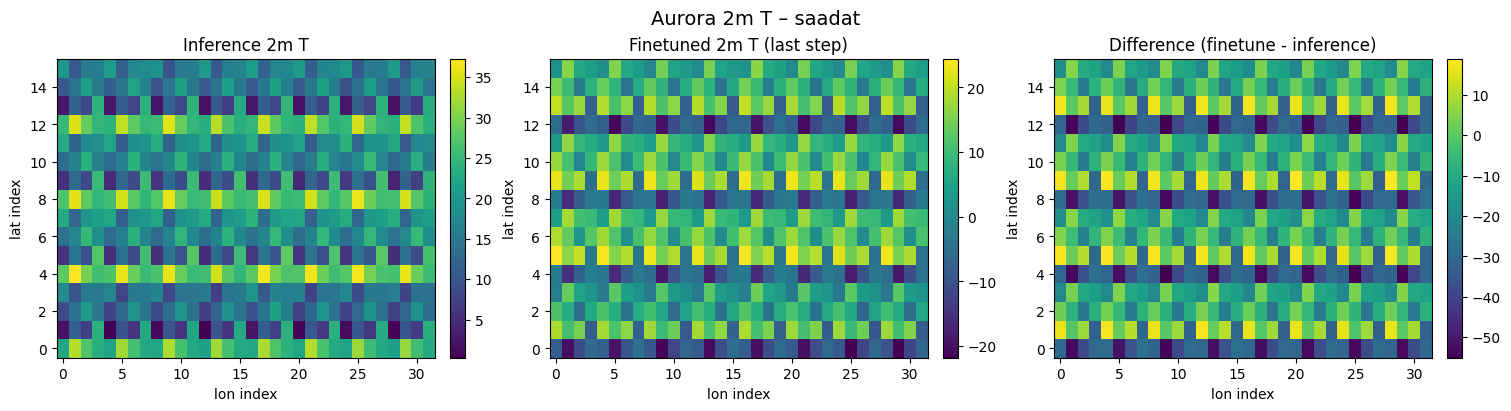

Loss history: [1.92902521e+13 1.69272924e+13 1.49668024e+13 1.35026830e+13
 1.25010077e+13]


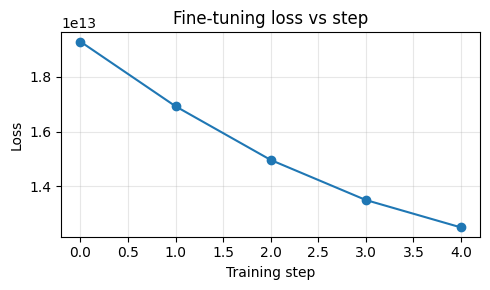

In [ ]:
# NOTE: what value does this have? All we see is that there's a big difference?
if has_finetune:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

    # Inference 2m T
    im0 = axes[0].imshow(inf_field, origin="lower", aspect="auto")
    axes[0].set_title("Inference 2m T")
    axes[0].set_xlabel("lon index")
    axes[0].set_ylabel("lat index")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Finetuned 2m T
    im1 = axes[1].imshow(fin_field, origin="lower", aspect="auto")
    axes[1].set_title("Finetuned 2m T (last step)")
    axes[1].set_xlabel("lon index")
    axes[1].set_ylabel("lat index")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Difference
    im2 = axes[2].imshow(diff_field, origin="lower", aspect="auto")
    axes[2].set_title("Difference (finetune - inference)")
    axes[2].set_xlabel("lon index")
    axes[2].set_ylabel("lat index")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    fig.suptitle(f"Aurora 2m T - {PARTICIPANT_ID}", fontsize=14)
    plt.show()
else:
    # Only inference available – plot just that
    plt.figure(figsize=(6, 3))
    im = plt.imshow(inf_field, origin="lower", aspect="auto")
    plt.colorbar(im, label="2m temperature (arb. units)")
    plt.title(f"Inference 2m T – {PARTICIPANT_ID}")
    plt.xlabel("lon index")
    plt.ylabel("lat index")
    plt.tight_layout()
    plt.show()


# 4. Plot fine-tuning loss vs step (if finetuning ran)
if losses_path.exists():
    losses = np.load(losses_path)
    print("Loss history:", losses)

    plt.figure(figsize=(5, 3))
    plt.plot(range(len(losses)), losses, marker="o")
    plt.title("Fine-tuning loss")
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(
        "No finetune_losses.npy found - either FINETUNE_STEPS was 0 or finetuning did not run."
    )


## Where to see results

- In Azure ML Studio → **Jobs** → open the job with the name printed above.
- Check the **Outputs + logs** tab:
